In [1]:
#kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import random
import math

In [2]:
# Belirtilen sayıda rastgele koordinat üretir
def generate_coordinates(n_points=50, x_range=(0, 100), y_range=(0, 100)):
    np.random.seed(42)
    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    return np.column_stack((x, y))

# 50 nokta üretelim
coordinates = generate_coordinates()


In [3]:
# Koordinatları referans noktasına olan uzaklıklara göre kümele
def cluster_by_reference(coordinates, reference_point, n_clusters=3):
    # Her noktanın referans noktasına olan Öklidyen uzaklığını hesapla
    distances = np.linalg.norm(coordinates - reference_point, axis=1)
    # Uzaklıklara göre verileri K-Means ile grupla (ama sadece uzaklık üzerinden)
    distances = distances.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(distances)
    return labels, kmeans.cluster_centers_

# Referans noktasını belirleyelim (örneğin ilk nokta)
reference = coordinates[0]
labels_ref, cluster_centers = cluster_by_reference(coordinates, reference)


c:\Users\pc\AppData\Local\spyder-6\envs\spyder-runtime\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


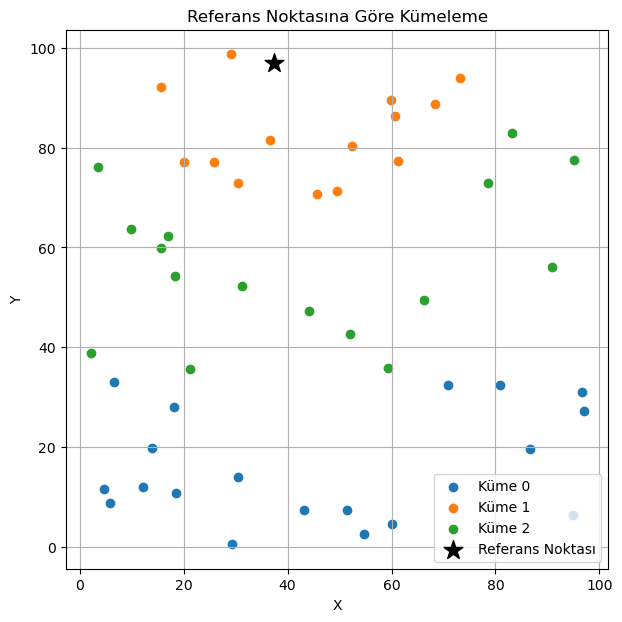

In [4]:
# Kümeleme sonuçlarını görselleştir
def plot_clusters(coords, labels, reference_point):
    plt.figure(figsize=(7, 7))
    for i in np.unique(labels):
        cluster = coords[labels == i]
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Küme {i}')
    plt.scatter(reference_point[0], reference_point[1], c='black', marker='*', s=200, label='Referans Noktası')
    plt.legend()
    plt.title("Referans Noktasına Göre Kümeleme")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

# Çizdirme işlemi
plot_clusters(coordinates, labels_ref, reference)


In [5]:
# ACO algoritması için yardımcı fonksiyonlar

# İki nokta arasındaki mesafeyi hesapla
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Tüm noktalar arası mesafe matrisini oluştur
def create_distance_matrix(coords):
    n = len(coords)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                matrix[i][j] = euclidean_distance(coords[i], coords[j])
    return matrix

# ACO algoritmasının kendisi
def ant_colony_optimization(dist_matrix, n_ants=10, n_iterations=100, alpha=1.0, beta=2.0, evaporation=0.5, Q=100):
    n_nodes = len(dist_matrix)
    pheromone = np.ones((n_nodes, n_nodes))  # Feromon matrisi
    best_path = None
    best_length = float('inf')

    for iteration in range(n_iterations):
        paths = []
        lengths = []

        for ant in range(n_ants):
            visited = [False] * n_nodes
            path = [0]
            visited[0] = True

            for _ in range(n_nodes - 1):
                current = path[-1]
                probabilities = []
                for next_node in range(n_nodes):
                    if not visited[next_node]:
                        tau = pheromone[current][next_node] ** alpha
                        eta = (1 / dist_matrix[current][next_node]) ** beta
                        probabilities.append(tau * eta)
                    else:
                        probabilities.append(0)
                probabilities = np.array(probabilities)
                probabilities /= probabilities.sum()
                next_city = np.random.choice(range(n_nodes), p=probabilities)
                path.append(next_city)
                visited[next_city] = True

            paths.append(path)
            length = sum(dist_matrix[path[i]][path[i+1]] for i in range(n_nodes - 1))
            length += dist_matrix[path[-1]][path[0]]  # Tura kapama
            lengths.append(length)

            if length < best_length:
                best_length = length
                best_path = path

        # Feromon güncellemesi
        pheromone *= (1 - evaporation)
        for i, path in enumerate(paths):
            for j in range(n_nodes - 1):
                pheromone[path[j]][path[j+1]] += Q / lengths[i]
            pheromone[path[-1]][path[0]] += Q / lengths[i]

    return best_path, best_length


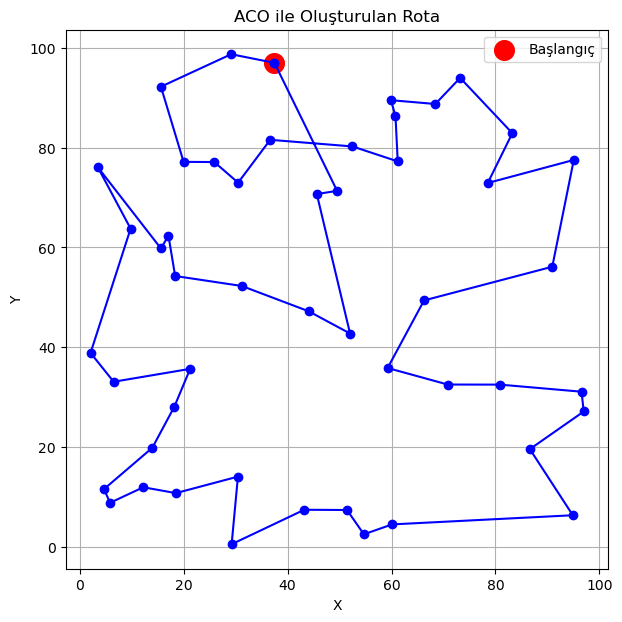

In [6]:
# Mesafe matrisi oluştur
dist_matrix = create_distance_matrix(coordinates)

# ACO ile en iyi rotayı bul
best_path, best_len = ant_colony_optimization(dist_matrix, n_ants=20, n_iterations=100)

# Rotayı çiz
def plot_route(coords, path, title="ACO ile Oluşturulan Rota"):
    plt.figure(figsize=(7, 7))
    x = [coords[i][0] for i in path + [path[0]]]
    y = [coords[i][1] for i in path + [path[0]]]
    plt.plot(x, y, marker='o', color='blue')
    plt.scatter(coords[0][0], coords[0][1], c='red', s=200, label='Başlangıç')
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_route(coordinates, best_path)
